In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

import numpy as np
import os, glob, atexit, signal
os.nice(19)
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gal1s = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gal2s = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

from common_func import *

In [3]:
LG1 = pklload(f"{database1}/LocalGroup.pickle")
LG2 = pklload(f"{database2}/LocalGroup.pickle")

In [13]:
allsats1 = None; allsubs1 = None; states1 = None
for key in LG1.keys():
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
print(len(allsubs1), np.unique(states1, return_counts=True))

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [14]:
allsats2 = None; allsubs2 = None; states2 = None
for key in LG2.keys():
    sats = LG2[key]['sats']; subs = LG2[key]['subs']; real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats2 = sats if allsats2 is None else np.hstack((allsats2, sats))
    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
print(len(allsubs2), np.unique(states2, return_counts=True))

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [10]:
nMW = np.genfromtxt("obs/NUMBER_MW.csv", comments='#', delimiter=',')
nMW[0]
nM31 = np.genfromtxt("obs/NUMBER_M31.csv", comments='#', delimiter=',')
nM31[0]

array([6.77738036, 9.868339  ])

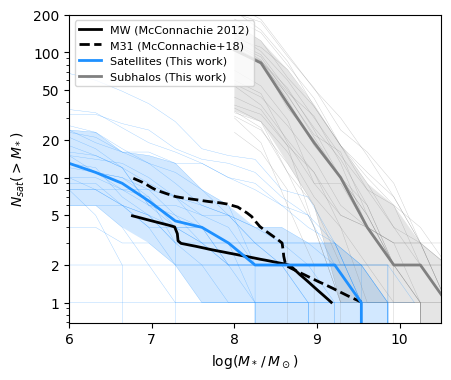

In [11]:
suffixs = ["all", "no_orp", "no_udg", "no_orp_udg"]
for ith in range(4):
    fig, ax = plt.subplots(figsize=(6*0.8,5*0.8))
    bins = np.logspace(6, 10.5, 15)
    hbins = np.logspace(8, 12.5, 15)

    chists1 = np.zeros((13, len(bins)-1))
    hhists1 = np.zeros((13, len(bins)-1))
    i=0
    for key in LG1.keys():
        if(not LG1[key]['isLG']): continue
        sats = LG1[key]['sats']
        subs = LG1[key]['subs']
        real = LG1[key]['real']
        if(ith%2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'orphan'])]
        if(ith//2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'upair'])]
        hist, he = np.histogram(subs['m'], bins = hbins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(he[:-1]), chist, color='grey', lw=0.25, alpha=0.5)
        hhists1[i] = chist
        hist, xe = np.histogram(sats['m'], bins = bins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(xe[:-1]), chist, color='dodgerblue', lw=0.25, alpha=0.5)
        chists1[i] = chist; i+=1

    chists2 = np.zeros((13, len(bins)-1))
    hhists2 = np.zeros((13, len(bins)-1))
    i=0
    for key in LG2.keys():
        if(not LG2[key]['isLG']): continue
        sats = LG2[key]['sats']
        subs = LG2[key]['subs']
        real = LG2[key]['real']
        if(ith%2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'orphan'])]
        if(ith//2==1): sats = sats[~isin(sats['id'], real['gid'][real['state'] == 'upair'])]
        hist, he = np.histogram(subs['m'], bins = hbins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(he[:-1]), chist, color='grey', lw=0.25, alpha=0.5)
        hhists2[i] = chist
        hist, xe = np.histogram(sats['m'], bins = bins)
        chist = np.cumsum(hist[::-1])[::-1]
        ax.plot(np.log10(xe[:-1]), chist, color='dodgerblue', lw=0.25, alpha=0.5)
        chists2[i] = chist; i+=1

    ax.plot(nMW[:,0], nMW[:,1], color='k', lw=2, ls='-', label='MW (McConnachie 2012)')
    ax.plot(nM31[:,0], nM31[:,1], color='k', lw=2, ls='--', label='M31 (McConnachie+18)')

    chists = np.vstack((chists1, chists2))
    q16, q50, q84 = np.percentile(chists, [16,50,84], axis=0)
    ax.fill_between(np.log10(xe[:-1]), q16, q84, alpha=0.2, fc='dodgerblue', ec='none')
    ax.plot(np.log10(xe[:-1]), q50, color='dodgerblue', lw=2, ls='-', label='Satellites (This work)')
    
    hhists = np.vstack((hhists1, hhists2))
    q16, q50, q84 = np.percentile(hhists, [16,50,84], axis=0)
    ax.fill_between(np.log10(he[:-1]), q16, q84, alpha=0.2, fc='grey', ec='none')
    ax.plot(np.log10(he[:-1]), q50, color='grey', lw=2, ls='-', label='Subhalos (This work)')


    ax.set_xlim(6,10.5)
    ax.set_xlabel(r"log($M_*\,/\,M_\odot$)")
    ax.set_yscale('log')
    ax.set_ylim(0.69, 200)
    ax.set_yticks([1,2,5,10,20,50,100,200])
    ax.set_yticklabels([1,2,5,10,20,50,100,200])
    ax.set_ylabel(r"$N_{sat}(>M_*)$")
    ax.legend(loc='upper left', frameon=True, fontsize=8)
    # plt.savefig(f"02_number_{suffixs[ith]}.png", dpi=400, transparent=False, bbox_inches='tight')
    plt.show(); plt.close()
    break

In [23]:
ssfrcut1 = 1 / (6*snap1.age*1e9); ssfrcut2 = 1 / (6*snap2.age*1e9)
sfms = np.genfromtxt("obs/SFMS.csv", comments='#', delimiter=',')
keys1 = np.array(list(LG1.keys())); keys2 = np.array(list(LG2.keys()))
mao = np.genfromtxt("obs/QF_SAGA.csv", comments='#', delimiter=',')
wetzel = np.genfromtxt("obs/QF_LG.csv", comments='#', delimiter=',')


  0%|          | 0/599 [00:00<?, ?it/s]

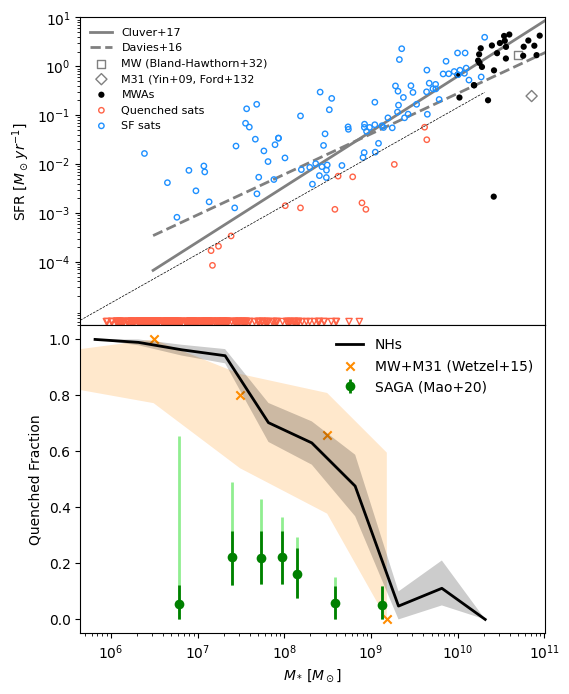

In [24]:
fig, axes = plt.subplots(2,1, figsize=(6,8), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
x1 = np.min(allsats1['m']*0.5); x2 = np.max(allsats1['m'])


allsats = np.hstack((allsats1, allsats2))
states = np.hstack((states1, states2))
#----------------------------------------------------------------
ax = axes[0]
xs = allsats['m']; ys = allsats['SFR_mem']*1.
mask_zero = ys==0; ys[mask_zero] = 6e-6
mask_q = (ys/xs) < ssfrcut1
mask_udg = allsats['id']<0

ax.plot(10**sfms[:2,0], 10**sfms[:2,1], color='grey', lw=2, ls='-', label='Cluver+17', zorder=-1)
ax.plot(10**sfms[2:4,0], 10**sfms[2:4,1], color='grey', lw=2, ls='--', label='Davies+16', zorder=-1)
ax.scatter(10**sfms[4,0], 10**sfms[4,1], fc='none',ec='grey', s=32, marker='s', label='MW (Bland-Hawthorn+32)', zorder=-1)
ax.scatter(10**sfms[5,0], 10**sfms[5,1], fc='none',ec='grey', s=32, marker='D', label='M31 (Yin+09, Ford+132', zorder=-1)

iii=0
for key in keys1:
    BGG = LG1[key]['BGG']
    if(iii==0): ax.scatter(BGG['m'], BGG['sfr'], s=20, fc='k', ec='none', marker='o', lw=0.5, zorder=1, label='MWAs')
    else: ax.scatter(BGG['m'], BGG['sfr'], s=20, fc='k', ec='none', marker='o', lw=0.5, zorder=1)
    iii+=1
for key in keys2:
    BGG = LG2[key]['BGG']
    ax.scatter(BGG['m'], BGG['sfr'], s=20, fc='k', ec='none', marker='o', lw=0.5, zorder=1)

ax.scatter(xs[~mask_zero & mask_q], ys[~mask_zero & mask_q], s=15, ec='tomato', fc='none', marker='o', label='Quenched sats')
ax.scatter(xs[~mask_zero & ~mask_q], ys[~mask_zero & ~mask_q], s=15, ec='dodgerblue', fc='none', marker='o', label='SF sats')
ax.scatter(xs[mask_zero], ys[mask_zero], s=20, ec='tomato', fc='none', marker='v')
ax.plot([x1,x2], [ssfrcut1*x1, ssfrcut1*x2], color='k', ls='--', lw=0.5)
ax.legend(loc='upper left', frameon=False, fontsize=8)

ax.set_yscale('log')
ax.set_ylim(5e-6, 10)
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
ax.set_ylabel(r"SFR $[M_\odot\,yr^{-1}]$")
ax.set_xscale('log')
ax.set_xlim(x1,x2)
#----------------------------------------------------------------

mmin=5.5; mmax = 10.5; mdex = 0.5
mbins = 10**np.arange(mmin, mmax+mdex, mdex); mleng = len(mbins)-1
MX = 0.5*(mbins[1:] + mbins[:-1])

#----------------------------------------------------------------
ax = axes[1]
ls = '-'
nboot = 599
QFs = np.zeros((nboot, mleng))
hist, _ = np.histogram(allsats['m'], bins = mbins)
for ib in tqdm(range(nboot)):
    sample = np.random.choice(allsats, len(allsats), replace=True)
    xs = sample['m']; ys = sample['SFR_mem']*1.
    mask_zero = ys==0; ys[mask_zero] = 6e-6; mask_q = (ys/xs) < ssfrcut1; mask = mask_zero | mask_q
    QF = np.zeros(mleng)
    for im in range(mleng):
        binmask = (xs > mbins[im]) & (xs < mbins[im+1])
        if(np.sum(binmask) == 0): QF[im] = np.nan
        else: QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
    QFs[ib] = QF
q16, q50, q84 = np.nanpercentile(QFs, [16,50,84], axis=0)

ax.fill_between(10**wetzel[:,0], wetzel[:,2], wetzel[:,3], alpha=0.2, ec='none', fc='darkorange')
ax.scatter(10**wetzel[:,0], wetzel[:,1], color='darkorange', marker='x', label=f'MW+M31 (Wetzel+15)')

ax.errorbar(10**mao[:,0], mao[:,1], yerr=[mao[:,1]-mao[:,2], mao[:,4]-mao[:,1]], 
            ms=6, mec='none',mfc='lightgreen', linewidth=0, ecolor='lightgreen', mew=2, elinewidth=2, marker='o', 
            color='lightgreen', ls='-')
ax.errorbar(10**mao[:,0], mao[:,1], yerr=[mao[:,1]-mao[:,2], mao[:,3]-mao[:,1]], 
            ms=7, mec='none',mfc='g', linewidth=0, ecolor='g', mew=2, elinewidth=2, marker='o', 
            color='g', ls='-', label='SAGA (Mao+20)')



ax.fill_between(MX, q16, q84, alpha=0.2, ec='none', fc='k')
ax.plot(MX, q50, color='k', lw=2, label=f'NHs', ls=ls)

# mask = mask_zero | mask_q
# QF = np.zeros(mleng)
# for im in range(mleng):
#     binmask = (xs > mbins[im]) & (xs < mbins[im+1])
#     if(np.sum(binmask) == 0): QF[im] = np.nan
#     QF[im] = np.sum(mask[binmask]) / np.sum(binmask)
# ax.plot(MX, QF, color='k', lw=2, label=f'NHs ({len(xs)})', zorder=3, ls=ls)


ax.set_xscale('log')
ax.set_xlim(x1,x2*5)
ax.set_xlabel(r"$M_*\,[M_\odot]$")
ax.set_ylabel("Quenched Fraction")
leg = ax.legend(frameon=False)
handles, labels = ax.get_legend_handles_labels()
order = [1,0,2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
#----------------------------------------------------------------
# plt.savefig("02_QFe.png", dpi=400, transparent=False, bbox_inches='tight')
plt.show(); plt.close()